In [1]:
import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm

from GeospatialFM.datasets.utils import get_ssl4eo_metadata
from GeospatialFM.data import apply_transforms, pretrain_transform, multimodal_collate_fn
from GeospatialFM.models import SpatialSpectralLowRankViTConfig, SpatialSpectralMAEViT
from GeospatialFM.models.low_rank_attention import get_perception_field_mask
from GeospatialFM.models import PositionalChannelEmbedding
from GeospatialFM.datasets import SSL4EODataset
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json

from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pca_vis_patch(patch, n_components=3):
    # perform PCA on patch
    pca = PCA(n_components=n_components)
    B, L, D = patch.shape
    patch_ = patch.reshape(B*L, D)
    try:
        patch_ = patch_.cpu().numpy()
    except:
        pass
    pca.fit(patch_)
    patch_pca = pca.transform(patch_)

    preprocessed_patches = patch_pca.reshape(B, int(L**0.5), int(L**0.5), 3)
    return preprocessed_patches

def norm_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

## SSL4EO

In [3]:
metadata = get_ssl4eo_metadata()
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]

In [4]:
dataset = dict(train=SSL4EODataset(root="/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO"))
apply_transform = partial(apply_transforms, optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std, use_8bit=False)
collate_fn = partial(multimodal_collate_fn, transform=pretrain_transform, normalization=apply_transform)

In [5]:
batch_size = 8

train_loader = DataLoader(
    dataset['train'], 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=collate_fn
)

## Model

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define configuration
config = SpatialSpectralLowRankViTConfig(
    patch_size=16,
    embed_dim=768,
    channel_embed_dims_per_head=1,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    decoder_channel_embed_dims_per_head=1,
    use_perception_field_mask=True,
    attention_radius=640,
    norm_pix_loss=False,
    decoder_out_chans = 15
)

# Initialize model
model = SpatialSpectralMAEViT(config)

## Training Code

In [7]:
# Set model to training mode
device = 'cuda:2'
model.to(device, dtype=torch.bfloat16)
model.train()
print()

In [8]:
# load checkpoint
model.load_state_dict(torch.load("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-Decode-Tokens/checkpoint-1000/pytorch_model.bin", map_location=device))

<All keys matched successfully>

In [9]:
batch = next(iter(train_loader))
optical = batch['optical'].to(device, dtype=torch.bfloat16)
radar = batch['radar'].to(device, dtype=torch.bfloat16)
optical_channel_wv = batch['optical_channel_wv']
radar_channel_wv = batch['radar_channel_wv']
spatial_resolution = batch['spatial_resolution']

In [10]:
model.eval()
with torch.no_grad():
    x, cls_token, patch_tokens, hidden_states = model.encoder(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, 
                                                                    spatial_resolution=spatial_resolution, mask_ratio=0, channel_mask_ratio=0.)
x, cls_token, patch_tokens = x.to(torch.float32).detach().cpu(), cls_token.to(torch.float32).detach().cpu(), patch_tokens.to(torch.float32).detach().cpu()

In [11]:
pca_patches = []
for hidden_state in hidden_states:
    hidden_state = hidden_state.to(torch.float32)
    # patches = hidden_state[:, 1:, 1:].mean(dim=1)
    patches = hidden_state[:, 0, 1:]
    patches = pca_vis_patch(patches.numpy())
    pca_patches.append(patches)

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:685: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


/tmp/ipykernel_4150232/1257146177.py:18: RuntimeWarning: invalid value encountered in divide
  image = image / image.max()


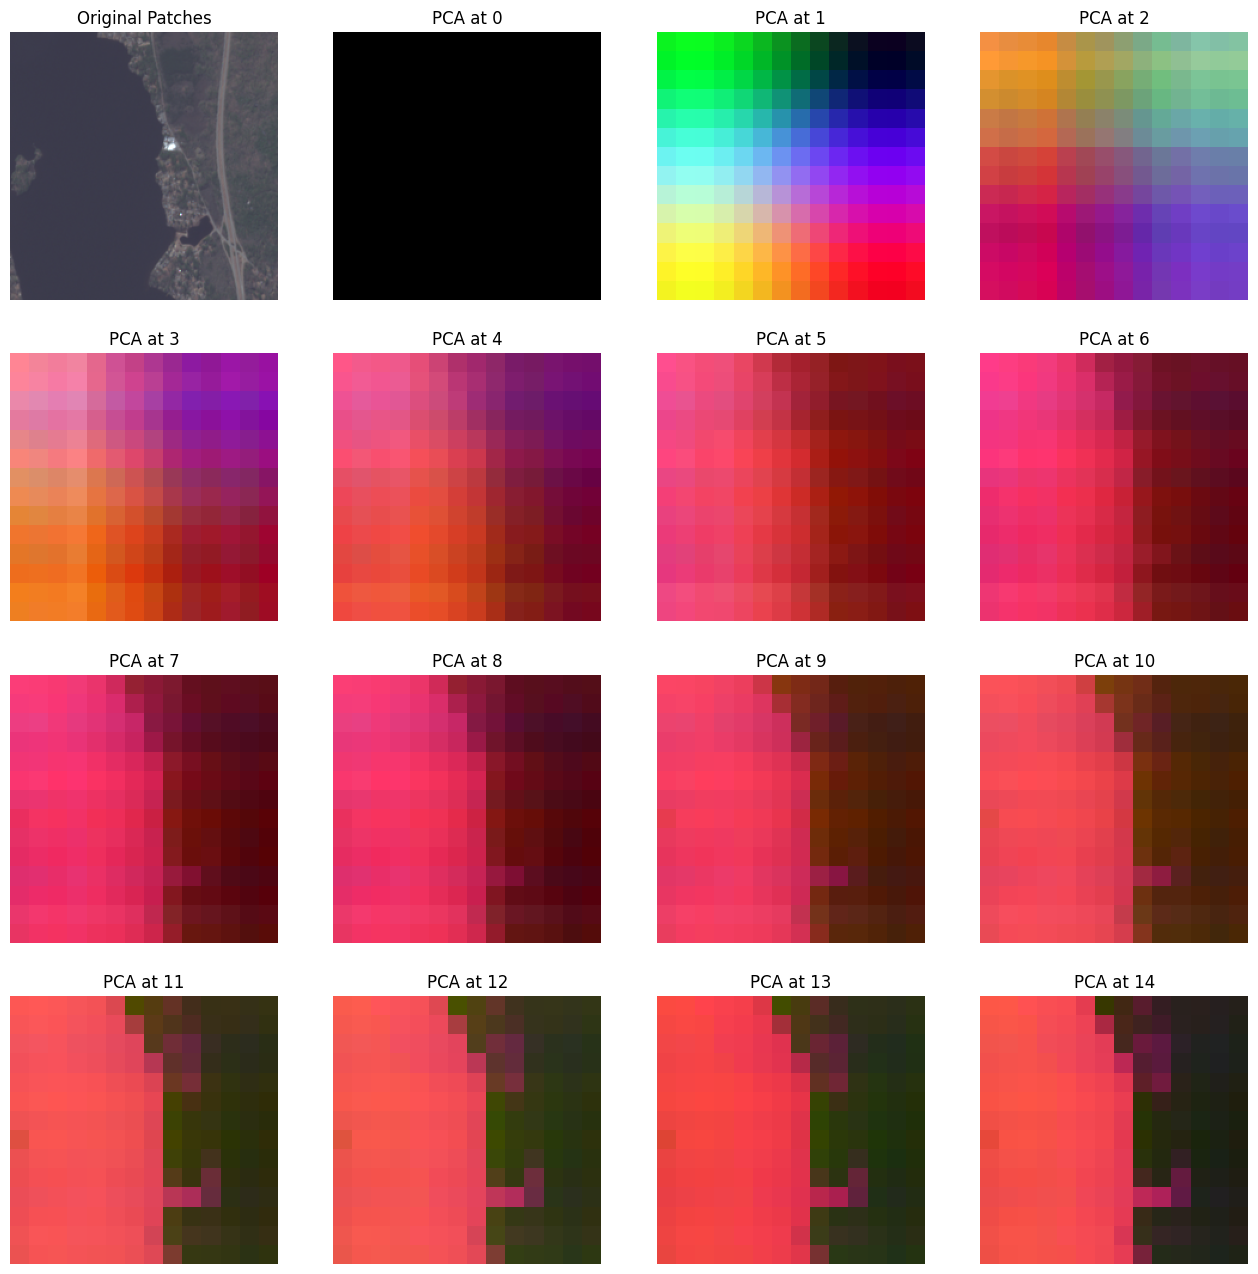

In [23]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

vis_idx = 7

for i in range(4):
    for j in range(4):
        index = i*4 + j
        if index == 0:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off')
        else:
            index -= 1
            axs[i, j].imshow(norm_image(pca_patches[index][vis_idx]))
            axs[i, j].set_title(f'PCA at {index}')
            axs[i, j].axis('off')

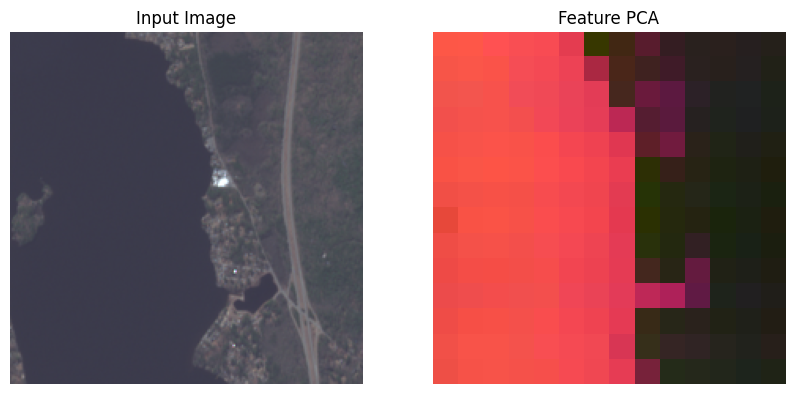

In [25]:
# visualize the first and the last PCA
vis_idx = 7
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
axs[0].set_title('Input Image')
axs[0].axis('off')
axs[1].imshow(norm_image(pca_patches[-1][vis_idx]))
axs[1].set_title('Feature PCA')
axs[1].axis('off')
plt.show()


In [26]:
model.train()
with torch.no_grad():
    output = model(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, spatial_resolution=spatial_resolution, mask_ratio=0.75, channel_mask_ratio=0.5)

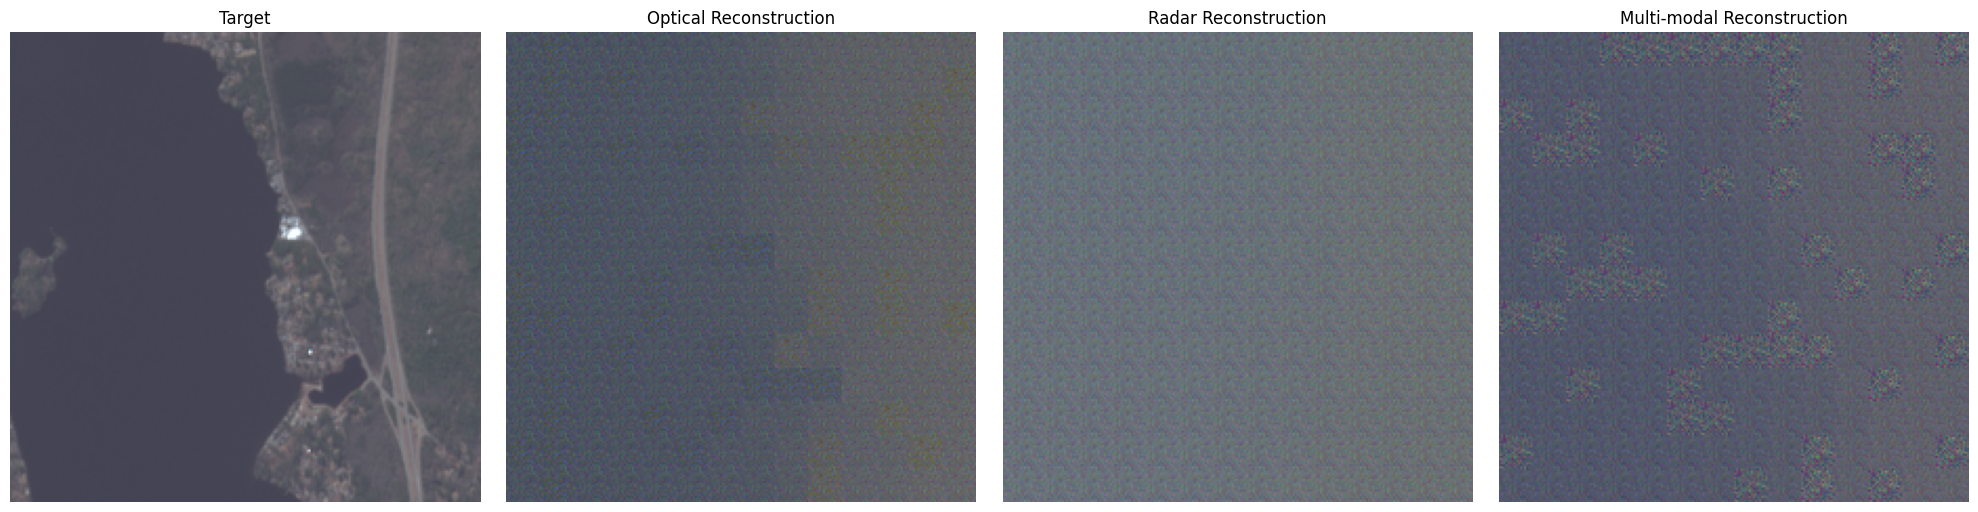

In [21]:
vis_idx = 7
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# all images are in RGB format
target_img = model.decoder.unpatchify(output['target'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
optical_img = model.decoder.unpatchify(output['optical_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
radar_img = model.decoder.unpatchify(output['radar_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
multi_img = model.decoder.unpatchify(output['multi_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)

# # normalize the images to be in [0, 1]
# target_img = norm_image(target_img)
# optical_img = norm_image(optical_img)
# radar_img = norm_image(radar_img)
# multi_img = norm_image(multi_img)

axs[0].imshow(target_img)
axs[0].set_title('Target')
axs[0].axis('off')

axs[1].imshow(optical_img)
axs[1].set_title('Optical Reconstruction')
axs[1].axis('off')

axs[2].imshow(radar_img)
axs[2].set_title('Radar Reconstruction')
axs[2].axis('off')

axs[3].imshow(multi_img)
axs[3].set_title('Multi-modal Reconstruction')
axs[3].axis('off')

plt.tight_layout()
plt.show()

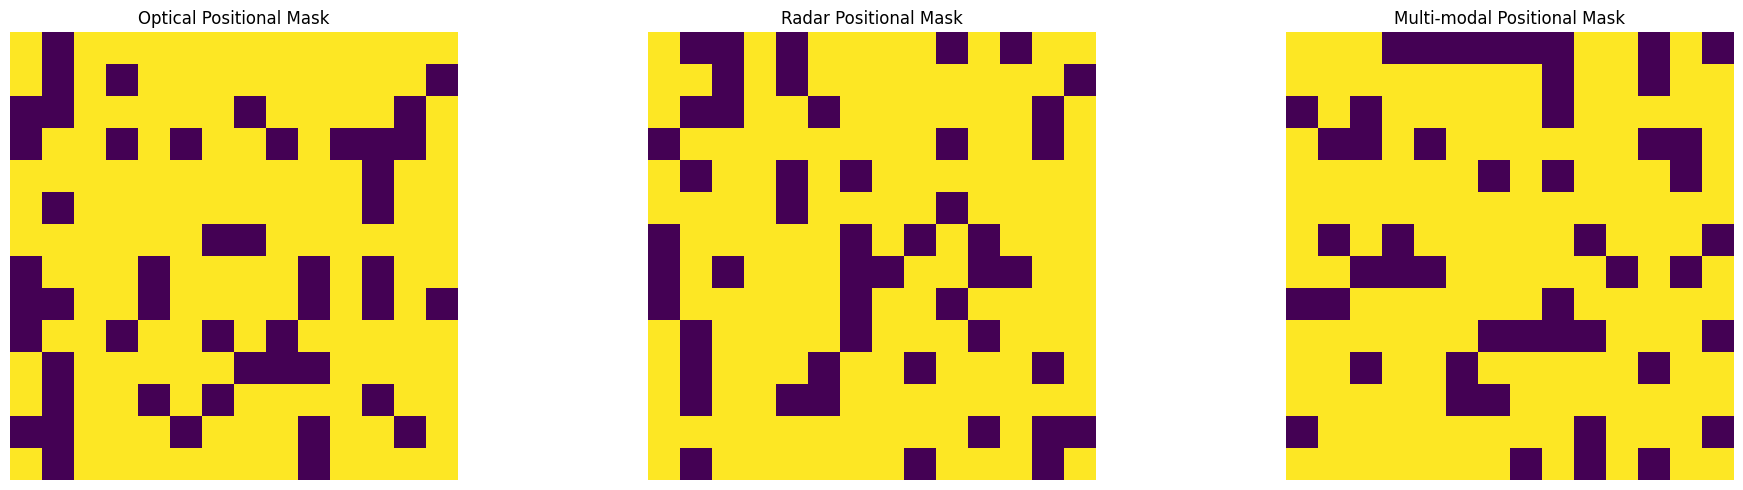

In [22]:
# visualize the spatial masks
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

n_patches = int(math.sqrt(output['optical_pos_mask'].shape[1]))

axs[0].imshow(output['optical_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[0].set_title('Optical Positional Mask')
axs[0].axis('off')

axs[1].imshow(output['radar_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[1].set_title('Radar Positional Mask')
axs[1].axis('off')

axs[2].imshow(output['multi_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[2].set_title('Multi-modal Positional Mask')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [18]:
output['multi_channel_mask'][0]

tensor([0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.],
       device='cuda:2')

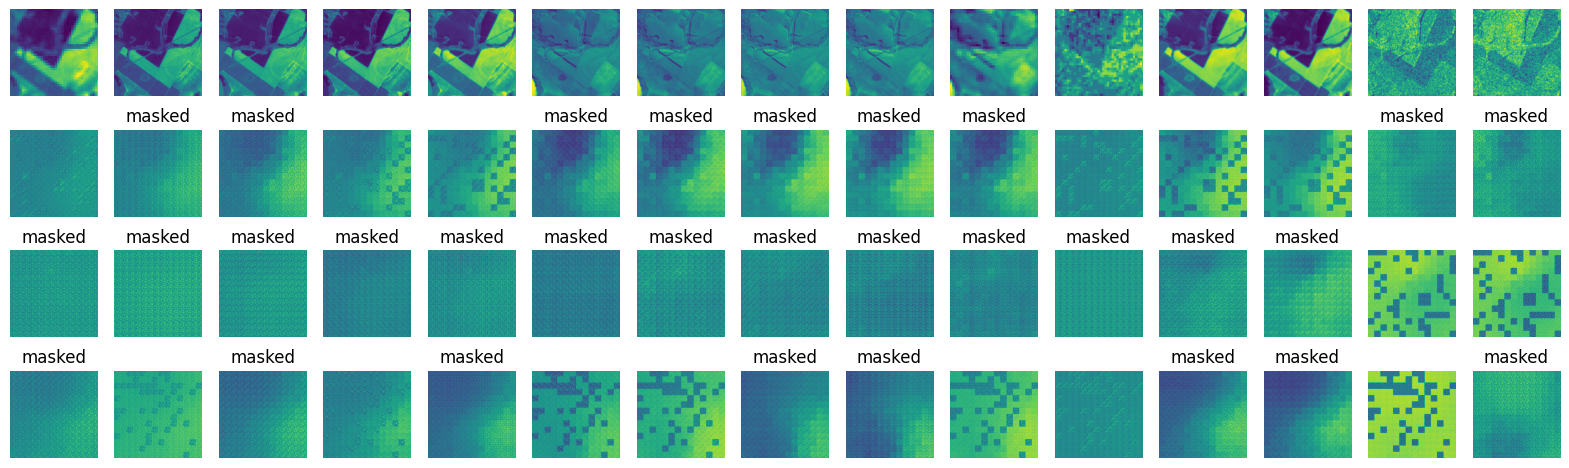

In [62]:
# visualize the reconstruction of every channel of every modality
vis_idx = 1
fig, axs = plt.subplots(4, 15, figsize=(20, 6))
target_img = model.decoder.unpatchify(output['target'])[vis_idx].detach().cpu().to(torch.float32).numpy()
for i in range(15):
    axs[0, i].imshow(target_img[i])
    axs[0, i].axis('off')
for j, modal in enumerate(['optical', 'radar', 'multi']):
    spatial_mask = output[f'{modal}_pos_mask']
    masked_patches = output[f'{modal}_recon'] * spatial_mask.unsqueeze(1).unsqueeze(-1).expand_as(output[f'{modal}_recon'])
    unmasked_patches = output['target'] * (1-spatial_mask).unsqueeze(1).unsqueeze(-1).expand_as(output['target'])
    
    masked_channel_img = model.decoder.unpatchify(output[f'{modal}_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_img = model.decoder.unpatchify(masked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    unmasked_img = model.decoder.unpatchify(unmasked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_pos_img = unmasked_img + masked_img
    
    channel_mask = output[f'{modal}_channel_mask'][vis_idx].detach().cpu().to(torch.bool).numpy()
    for i in range(15):
        if channel_mask[i]:
            axs[j+1, i].imshow(masked_channel_img[i])
            axs[j+1, i].axis('off')
            axs[j+1, i].set_title('masked')
        else:
            # axs[j+1, i].imshow(masked_pos_img[i])
            axs[j+1, i].imshow(masked_channel_img[i])
            # axs[j+1, i].imshow(masked_img[i])
            axs[j+1, i].axis('off')
plt.show()

In [29]:
len(decoder_pca_patches)

10

In [55]:
decoder_pca_patches = []
for hidden_state in output['optical_hidden_states']:
    hidden_state = hidden_state.to(torch.float32).detach().cpu()
    # patches = hidden_state[:, 1:, 1:].mean(dim=1)
    # patches = hidden_state[:, 3, 1:]
    patches = hidden_state[:, 0, 1:]
    patches = pca_vis_patch(patches.numpy())
    decoder_pca_patches.append(patches)

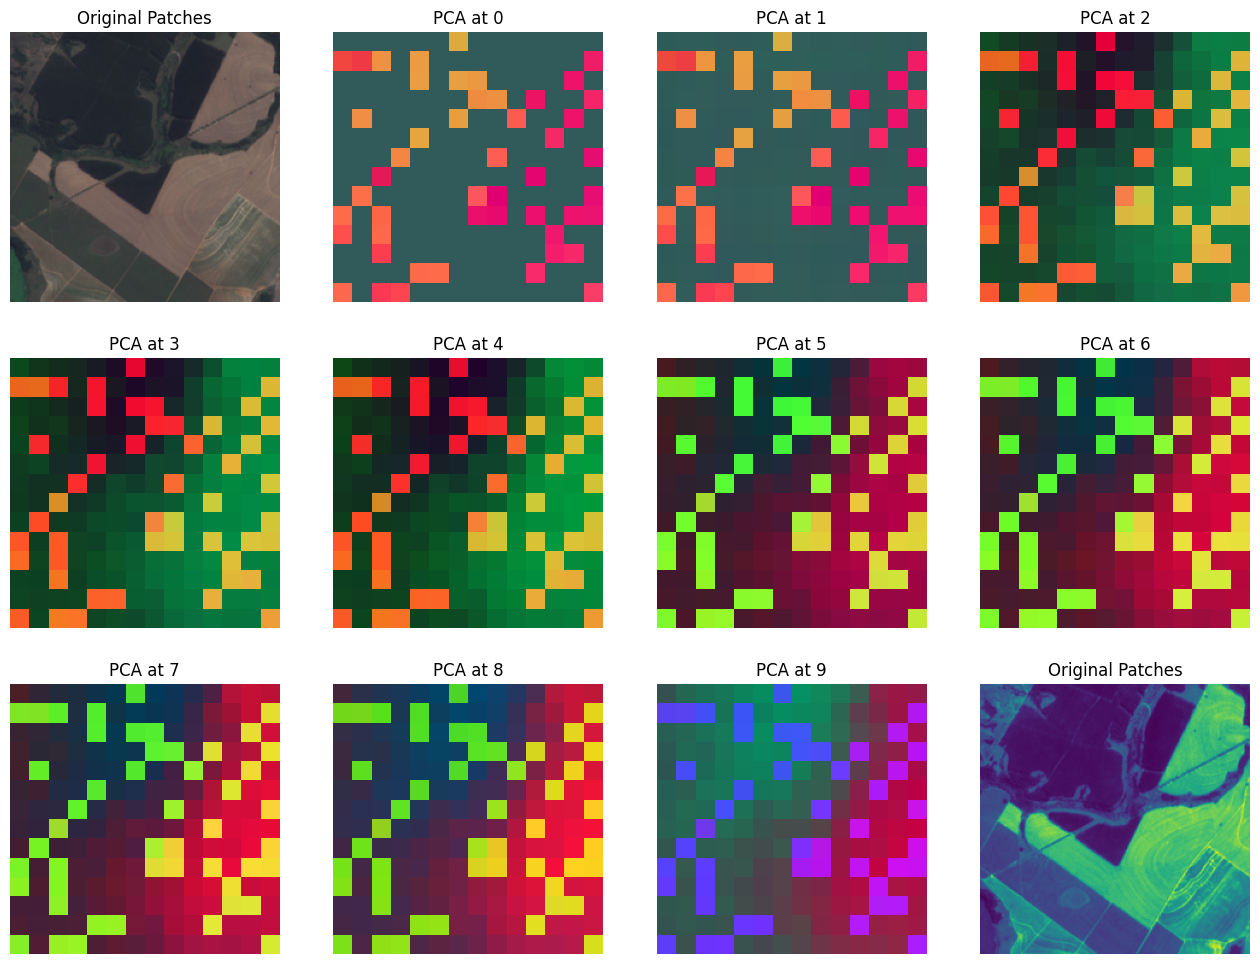

In [56]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

vis_idx = 1

for i in range(3):
    for j in range(4):
        index = i*4 + j
        if index == 0:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off')
        elif index == 11:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off')
        else:
            index -= 1
            axs[i, j].imshow(norm_image(decoder_pca_patches[index][vis_idx]))
            axs[i, j].set_title(f'PCA at {index}')
            axs[i, j].axis('off')
plt.show()

In [60]:
decoder_pca_patches = []
for hidden_state in output['optical_hidden_states']:
    hidden_state = hidden_state.to(torch.float32).detach().cpu()
    # patches = hidden_state[:, 1:, 1:].mean(dim=1)
    # patches = hidden_state[:, 3, 1:]
    patches = hidden_state[:, :, 0]
    patches = pca_vis_patch(patches.numpy())
    decoder_pca_patches.append(patches)

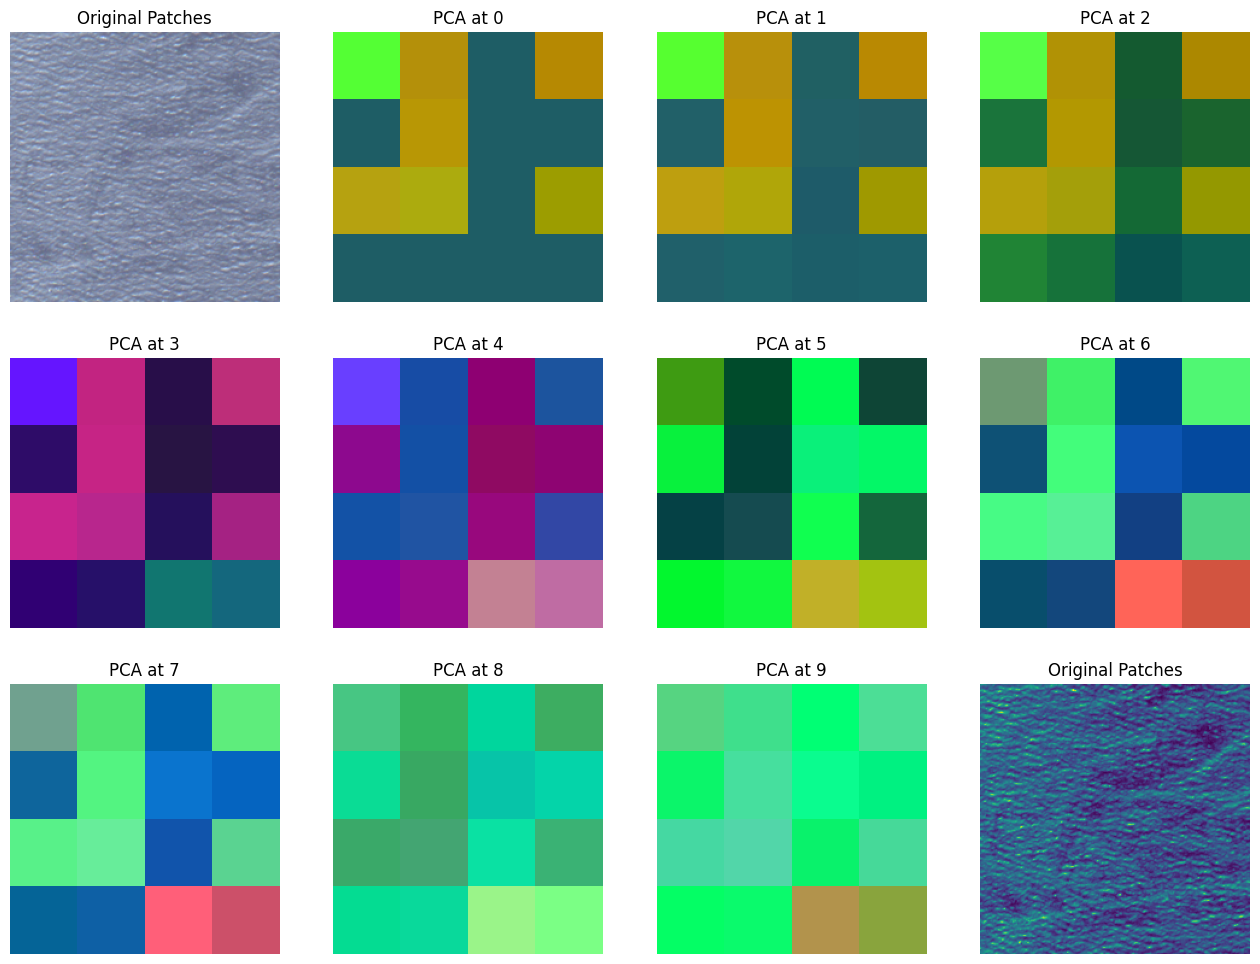

In [66]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

vis_idx = 0

for i in range(3):
    for j in range(4):
        index = i*4 + j
        if index == 0:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off')
        elif index == 11:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off')
        else:
            index -= 1
            axs[i, j].imshow(norm_image(decoder_pca_patches[index][vis_idx]))
            axs[i, j].set_title(f'PCA at {index}')
            axs[i, j].axis('off')

In [14]:
inp = torch.randn(1, 15, 197, 512)
conv = nn.Conv2d(15 * 512, 15 * 256, kernel_size=1, groups=15, bias=True)
out = conv(inp.view(1, 15 * 512, 197, 1)).view(1, 15, 197, 256)
print(out.shape)

torch.Size([1, 15, 197, 256])


In [7]:
out = conv(inp)
print(out.shape)

RuntimeError: Given groups=1, weight of size [256, 512, 1, 15, 197], expected input[1, 1, 512, 15, 197] to have 512 channels, but got 1 channels instead

In [53]:
tokens = torch.tensor([True] * 4 + [False] * 12)

mask = [torch.randperm(16) for _ in range(8)]
mask = torch.stack([tokens[m] for m in mask])
mask_indices = mask.nonzero(as_tuple=False)
max_L = mask_indices.shape[0] // 8

In [57]:
mask_indices = mask.nonzero(as_tuple=True)[1]
mask_indices

tensor([ 7,  9, 13, 15,  0,  1,  3,  7,  0,  8, 12, 14,  1,  2, 13, 14,  0,  2,
         6, 13,  8, 10, 13, 14,  5,  6,  9, 13,  2,  8, 11, 15])

In [55]:
mask_indices.shape

torch.Size([32, 2])

In [58]:
x = torch.randn(8, 196, 16, 512)
B, C, N, D = x.shape

mask_indices = mask_indices.reshape(B, -1, 1, 1).expand(-1, -1, C, D)

In [60]:
mask_indices

tensor([[[[ 7,  7,  7,  ...,  7,  7,  7],
          [ 7,  7,  7,  ...,  7,  7,  7],
          [ 7,  7,  7,  ...,  7,  7,  7],
          ...,
          [ 7,  7,  7,  ...,  7,  7,  7],
          [ 7,  7,  7,  ...,  7,  7,  7],
          [ 7,  7,  7,  ...,  7,  7,  7]],

         [[ 9,  9,  9,  ...,  9,  9,  9],
          [ 9,  9,  9,  ...,  9,  9,  9],
          [ 9,  9,  9,  ...,  9,  9,  9],
          ...,
          [ 9,  9,  9,  ...,  9,  9,  9],
          [ 9,  9,  9,  ...,  9,  9,  9],
          [ 9,  9,  9,  ...,  9,  9,  9]],

         [[13, 13, 13,  ..., 13, 13, 13],
          [13, 13, 13,  ..., 13, 13, 13],
          [13, 13, 13,  ..., 13, 13, 13],
          ...,
          [13, 13, 13,  ..., 13, 13, 13],
          [13, 13, 13,  ..., 13, 13, 13],
          [13, 13, 13,  ..., 13, 13, 13]],

         [[15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          [15, 15, 15,  ..., 15, 15, 15],
          ...,
          [15, 15, 15,  ..., 15, 15, 15],
          

In [47]:
x = x.gather(2, mask_indices)
x.shape, mask_indices.shape

(torch.Size([8, 8, 196, 512]), torch.Size([8, 8, 196, 512]))

In [39]:
indices = indices.view(B, -1, 1, 1).expand(-1, -1, C, D)

torch.Size([32, 2])

In [32]:
tokens[mask[0]]

tensor([False, False, False, False, False, False,  True, False, False, False,
        False,  True,  True, False, False,  True])

In [34]:
tokens

tensor([ True,  True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False])

In [37]:
torch.stack([tokens[m] for m in mask])

tensor([[ True, False, False, False,  True, False, False, False,  True, False,
          True, False, False, False, False, False],
        [False, False, False, False, False, False,  True, False,  True, False,
         False, False,  True, False,  True, False],
        [False, False, False,  True,  True, False,  True, False, False, False,
         False, False, False,  True, False, False],
        [False, False,  True, False, False, False, False,  True, False, False,
         False,  True, False, False,  True, False],
        [False, False, False, False, False,  True, False, False, False, False,
         False,  True, False,  True, False,  True],
        [False, False,  True, False,  True, False,  True, False, False, False,
         False, False, False, False,  True, False],
        [False,  True, False, False, False, False, False, False,  True, False,
         False,  True, False,  True, False, False],
        [False, False,  True, False, False, False, False, False, False, False,
    